## Installing the required packages

In [ ]:
!pip install datasets # Hugging Face Datasets library to download the data from the Hugging Face Dataset Hub.
!pip install umap-learn # to reduce the hidden states(dimension reduction)
!pip install transformers # Hugging Face Transformers library to download transformers model
!pip install optuna # optimization framework designed for hypermarameter searching

## Downloading the emotion dataset

In [5]:
from datasets import load_dataset

In [6]:
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Visualizing data as a Pandas dataframe

In [8]:
import pandas as pd

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row, split):
    return emotions[split].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Let's visualize our data

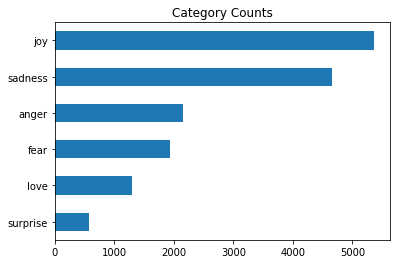

In [11]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

##### We can see that the dataset is heavily imbalanced

## Visualizing tweet length per class

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


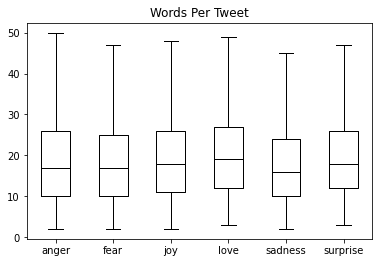

In [12]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by='label_name', grid=False, showfliers=False,
           color='black', )
plt.suptitle("")
plt.xlabel("");

## Instantiating AutoTokenizer for DistilBERT model

In [15]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
tokenizer.vocab_size

30522

In [17]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [18]:
tokenizer.model_max_length

512

## Instantiating the DistilBERT model using AutoModel

In [21]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Tokenizinng our dataset

In [27]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [28]:
emotions.reset_format()

In [30]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
emotions_encoded["train"]

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text'],
    num_rows: 16000
})

## Extracting features using the pretrained transformer

In [32]:
import numpy as np

def forward_pass(batch):
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state.cpu().numpy()

    # Use average of unmasked hidden states for classification
    lhs_shape = last_hidden_state.shape
    boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
    boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
    boolean_mask = boolean_mask.reshape(lhs_shape)
    masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
    batch["hidden_state"] = masked_mean.data
    return batch

extracted_features = emotions_encoded.map(forward_pass, batched=True,batch_size=16)

  0%|          | 0/1000 [00:00<?, ?ba/s]

  0%|          | 0/125 [00:00<?, ?ba/s]

  0%|          | 0/125 [00:00<?, ?ba/s]

## Creating train and validation set from extracted features

In [33]:
import numpy as np

X_train = np.array(extracted_features["train"]["hidden_state"])
X_valid = np.array(extracted_features["validation"]["hidden_state"])
y_train = np.array(extracted_features["train"]["label"])
y_valid = np.array(extracted_features["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Dimension reduction using UMAP

In [34]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
reduced_features = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
reduced_features['label'] = y_train
reduced_features.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,6.266446,5.552454,0
1,1.907982,4.989771,0
2,5.913362,2.560973,3
3,2.555734,3.354831,2
4,0.784561,7.385767,3


In [35]:
reduced_features.shape

(16000, 3)

## Ploting our features vector for different classes

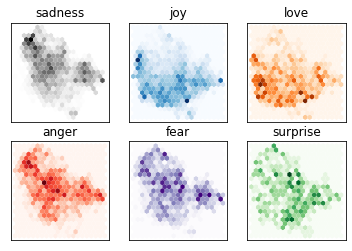

In [36]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = ['sadness', 'joy', 'love', 'anger','fear', 'surprise']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    reduced_features_sub = reduced_features.query(f"label == {i}")
    axes[i].hexbin(reduced_features_sub["X"], reduced_features_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

## Creating the trainable classifier model

In [37]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

## Type-casting our dataset to  tensor format

In [38]:
extracted_features.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [39]:
extracted_features["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Defining helper function for model evaluation

In [40]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## Feeding training arguments

In [41]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

## Training our first model

In [42]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.789800,0.300666,0.908500,0.905196
2,0.240000,0.214205,0.929000,0.929143


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-250
Configuration saved in results/checkpoint-250/config.json
Model weights saved in results/checkpoint-250/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-500 (score: 0.9291431890992695).


## Evaluating our model

In [43]:
results = trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


## Hyperparameter searching for improving model performance

In [44]:
train_subset = emotions_encoded["train"].shard(index=1, num_shards=10)
eval_subset = emotions_encoded["validation"].shard(index=1, num_shards=10)

In [45]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels)

In [48]:
trainer = Trainer(model_init=model_init, args=training_args,
                  compute_metrics=compute_metrics, train_dataset=train_subset,
                  eval_dataset=eval_subset)
best_run = trainer.hyperparameter_search(n_trials=3, direction="maximize")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.505638,0.830000,0.806401
2,0.946100,0.211020,0.935000,0.934484
3,0.273400,0.233122,0.935000,0.933554
4,0.111200,0.251898,0.935000,0.934884
5,0.048800,0.285778,0.935000,0.934627


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-0/checkpoint-200
Configuration saved in results/run-0/checkpoint-200/config.json
Model weights saved in results/run-0/checkpoint-200/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-0/checkpoint-400
Configuration saved in results/run-0/checkpoint-400/config.json
Model weights saved in results/run-0/checkpoint-400/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.638591,0.830000,0.822272
2,0.951200,0.288338,0.920000,0.920221
3,0.279200,0.319945,0.900000,0.900374


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-1/checkpoint-200
Configuration saved in results/run-1/checkpoint-200/config.json
Model weights saved in results/run-1/checkpoint-200/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-1/checkpoint-400
Configuration saved in results/run-1/checkpoint-400/config.json
Model weights saved in results/run-1/checkpoint-400/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.356336,0.540000,0.444565
2,No log,0.932312,0.735000,0.672481
3,No log,0.756575,0.745000,0.686572
4,No log,0.634003,0.770000,0.728340
5,0.940200,0.602620,0.780000,0.742797


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-2/checkpoint-50
Configuration saved in results/run-2/checkpoint-50/config.json
Model weights saved in results/run-2/checkpoint-50/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to results/run-2/checkpoint-100
Configuration saved in results/run-2/checkpoint-100/config.json
Model weights saved in results/run-2/checkpoint-100/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and hav

## Training our model with best hyperparameters

In [49]:
for key, value in best_run.hyperparameters.items():
    setattr(trainer.args, key, value)

trainer.train_dataset = emotions_encoded["train"]
trainer.eval_dataset = emotions_encoded["validation"]
trainer.train();

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.258600,0.224260,0.929000,0.927949
2,0.176700,0.170870,0.938500,0.938923
3,0.153200,0.240002,0.937000,0.936293
4,0.088800,0.255037,0.943000,0.942957
5,0.032500,0.267640,0.945000,0.945258


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-2000
Configuration saved in results/checkpoint-2000/config.json
Model weights saved in results/checkpoint-2000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-4000
Configuration saved in results/checkpoint-4000/config.json
Model weights saved in results/checkpoint-4000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_st

## Predicting with our new model

In [50]:
preds_output = trainer.predict(emotions_encoded["validation"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


In [51]:
preds_output.metrics

{'test_accuracy': 0.945,
 'test_f1': 0.9452577751980675,
 'test_loss': 0.26764020323753357,
 'test_runtime': 4.909,
 'test_samples_per_second': 407.411,
 'test_steps_per_second': 6.519}

In [52]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.97      0.98      0.97       550
         joy       0.97      0.94      0.95       704
        love       0.86      0.93      0.89       178
       anger       0.96      0.95      0.95       275
        fear       0.90      0.92      0.91       212
    surprise       0.85      0.85      0.85        81

    accuracy                           0.94      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.95      0.94      0.95      2000



In [76]:
custom_tweet = "If you do that again, I will kill you"
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to("cuda")
logits = model(input_tensor).logits

In [77]:
logits

tensor([[ 0.6760, -1.0263, -1.5426,  2.3848,  0.2339, -1.8779]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [78]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [79]:
probs

array([0.13273339, 0.0241934 , 0.01443584, 0.73301154, 0.08530194,
       0.01032387], dtype=float32)

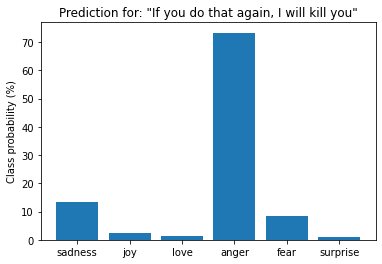

In [80]:
plt.bar(labels, 100 * probs, color='C0')
plt.title(f'Prediction for: "{custom_tweet}"')
plt.ylabel("Class probability (%)");

In [81]:
trainer.save_model("distilbert-emotion")
tokenizer.save_pretrained("distilbert-emotion")

Saving model checkpoint to distilbert-emotion
Configuration saved in distilbert-emotion/config.json
Model weights saved in distilbert-emotion/pytorch_model.bin
tokenizer config file saved in distilbert-emotion/tokenizer_config.json
Special tokens file saved in distilbert-emotion/special_tokens_map.json


('distilbert-emotion/tokenizer_config.json',
 'distilbert-emotion/special_tokens_map.json',
 'distilbert-emotion/vocab.txt',
 'distilbert-emotion/added_tokens.json',
 'distilbert-emotion/tokenizer.json')